# Node2Vec on DBLP Citation Graph.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Loading the DBLP dataset 
The data was a whooping 12 GBs, too big for performing EDA and prototyping. It was divided into smaller chunks which is wwhat you see below.

In [ ]:
!ls /content/drive/My\ Drive/CSE575_Project/Datasets/dataset_splitted

titles_bdlp_v11_data.csv  xbi  xcr  xea  xfj  xgs  xib	xjk  xkt  xmc  xnl  xou
xaa			  xbj  xcs  xeb  xfk  xgt  xic	xjl  xku  xmd  xnm  xov
xab			  xbk  xct  xec  xfl  xgu  xid	xjm  xkv  xme  xnn  xow
xac			  xbl  xcu  xed  xfm  xgv  xie	xjn  xkw  xmf  xno  xox
xad			  xbm  xcv  xee  xfn  xgw  xif	xjo  xkx  xmg  xnp  xoy
xae			  xbn  xcw  xef  xfo  xgx  xig	xjp  xky  xmh  xnq  xoz
xaf			  xbo  xcx  xeg  xfp  xgy  xih	xjq  xkz  xmi  xnr  xpa
xag			  xbp  xcy  xeh  xfq  xgz  xii	xjr  xla  xmj  xns  xpb
xah			  xbq  xcz  xei  xfr  xha  xij	xjs  xlb  xmk  xnt  xpc
xai			  xbr  xda  xej  xfs  xhb  xik	xjt  xlc  xml  xnu  xpd
xaj			  xbs  xdb  xek  xft  xhc  xil	xju  xld  xmm  xnv  xpe
xak			  xbt  xdc  xel  xfu  xhd  xim	xjv  xle  xmn  xnw  xpf
xal			  xbu  xdd  xem  xfv  xhe  xin	xjw  xlf  xmo  xnx  xpg
xam			  xbv  xde  xen  xfw  xhf  xio	xjx  xlg  xmp  xny  xph
xan			  xbw  xdf  xeo  xfx  xhg  xip	xjy  xlh  xmq  xnz  xpi
xao			  xbx  xdg  xep  xfy  xhh  xiq	xjz  xli  xmr  xoa  xpj
xap			

## Networkx is a beast
it provides many tools and algorithms that can be run on the graph (Shortest path from A to B, connected components, drawing and visualizing)



In [ ]:
!pip install networkx

In [ ]:
import networkx as nx
from networkx.readwrite import json_graph
import pandas as pd
import json
import math 
import numpy as np
from os import listdir
from os.path import isfile, join

# **LOAD DATA**

In [ ]:
path = '/content/drive/My Drive/CSE575_Project/Datasets/dataset_splitted/'
filename_list = [f for f in listdir(path) if isfile(join(path, f))]
filename_list

parsing json file chunks to one dataframe, this can be adjusted for smaller chunks.

In [ ]:
pd.read_json(path+'xaa',lines=True).head

<bound method NDFrame.head of               id  ...                                   indexed_abstract
0      100001334  ...                                                NaN
1     1000018889  ...  {'IndexLength': 173, 'InvertedIndex': {'Both':...
2     1000022707  ...  {'IndexLength': 49, 'InvertedIndex': {'A': [0]...
3      100004108  ...  {'IndexLength': 82, 'InvertedIndex': {'In': [0...
4       10000571  ...  {'IndexLength': 171, 'InvertedIndex': {'Comple...
...          ...  ...                                                ...
9995   105154181  ...                                                NaN
9996   105154304  ...                                                NaN
9997    10515480  ...  {'IndexLength': 101, 'InvertedIndex': {'Over':...
9998   105155086  ...                                                NaN
9999   105155515  ...  {'IndexLength': 300, 'InvertedIndex': {'Advanc...

[10000 rows x 16 columns]>

In [ ]:
filename_list = [f for f in listdir(path) if isfile(join(path, f))]
df = pd.DataFrame()

for filename in filename_list:
  df = df.append(pd.read_json(path+filename,lines=True).filter(['id','title', 'authors','year','references']))
  print(filename, end ="")
 



## Checkpoint for using csv directly

In [ ]:
df.to_csv('titles_bdlp_v11_data.csv')
!cp titles_bdlp_v11_data.csv drive/My\ Drive/

In [ ]:
df

,id,title,authors,year,references
0,100001334,Ontologies in HYDRA - Middleware for Ambient I...,"[{'name': 'Peter Kostelnik', 'id': '2702511795...",2009.0,NaN
1,1000018889,Remote Policy Enforcement for Trusted Applicat...,"[{'name': 'Fabio Martinelli', 'id': '210743870...",2013.0,"[94181602, 1504669610, 1542792105, 1639158619,..."
2,1000022707,A SIMPLE OBSERVATION REGARDING ITERATIONS OF F...,"[{'name': 'Jerzy Mycka', 'id': '263067851'}]",2009.0,"[1972178849, 2069792094]"
3,100004108,Gait based human identity recognition from mul...,"[{'name': 'Emdad Hossain', 'id': '2017661848',...",2012.0,"[1578000111, 2120433720, 2136461127, 213893135..."
4,10000571,The GAME Algorithm Applied to Complex Fraction...,"[{'name': 'Pavel Kordík', 'id': '419063071', '...",2008.0,"[291899685, 1964166287, 2135293965, 2146842127..."
...,...,...,...,...,...
7335,999974056,Integrated Pollutants Control Equipment Optimi...,"[{'name': 'Xiaowen Hao', 'id': '2580939372', '...",2013.0,[]
7336,999990983,On Density in Coordination Languages,"[{'name': 'Jean-Marie Jacquet', 'id': '2010907...",2013.0,"[1500859230, 1580092362, 1585392506, 169252172..."
7337,999994435,Investigating the metabolic landscape alterati...,"[{'name': 'Xiaofeng Zhang', 'id': '2103773916'}]",2015.0,NaN
7338,99999725,Validating Referential Integrity as a Database...,"[{'name': 'Coral Calero', 'id': '2106620005'},...",1999.0,NaN


In [ ]:
filepath = '/content/drive/My Drive/titles_bdlp_v11_data.csv'
df_graph = pd.read_csv(filepath)
df_graph = df_graph.drop(columns='Unnamed: 0')
df_graph = df_graph.fillna('0')

In [ ]:
df_graph

,id,title,authors,year,references
0,100001334,Ontologies in HYDRA - Middleware for Ambient I...,"[{'name': 'Peter Kostelnik', 'id': '2702511795...",2009,0
1,1000018889,Remote Policy Enforcement for Trusted Applicat...,"[{'name': 'Fabio Martinelli', 'id': '210743870...",2013,"['94181602', '1504669610', '1542792105', '1639..."
2,1000022707,A SIMPLE OBSERVATION REGARDING ITERATIONS OF F...,"[{'name': 'Jerzy Mycka', 'id': '263067851'}]",2009,"['1972178849', '2069792094']"
3,100004108,Gait based human identity recognition from mul...,"[{'name': 'Emdad Hossain', 'id': '2017661848',...",2012,"['1578000111', '2120433720', '2136461127', '21..."
4,10000571,The GAME Algorithm Applied to Complex Fraction...,"[{'name': 'Pavel Kordík', 'id': '419063071', '...",2008,"['291899685', '1964166287', '2135293965', '214..."
...,...,...,...,...,...
4107335,999974056,Integrated Pollutants Control Equipment Optimi...,"[{'name': 'Xiaowen Hao', 'id': '2580939372', '...",2013,[]
4107336,999990983,On Density in Coordination Languages,"[{'name': 'Jean-Marie Jacquet', 'id': '2010907...",2013,"['1500859230', '1580092362', '1585392506', '16..."
4107337,999994435,Investigating the metabolic landscape alterati...,"[{'name': 'Xiaofeng Zhang', 'id': '2103773916'}]",2015,0
4107338,99999725,Validating Referential Integrity as a Database...,"[{'name': 'Coral Calero', 'id': '2106620005'},...",1999,0


## Pre-processing list of references 

In [ ]:
yello = df_graph['references'].apply(lambda x:x.replace('"[', ''))
yello = yello.apply(lambda x:x.replace('[', ''))
yello = yello.apply(lambda x:x.replace(']', ''))
yello = yello.apply(lambda x:x.replace("' ", ""))
yello = yello.apply(lambda x:x.replace(" '", ""))
yello = yello.apply(lambda x:x.replace("'", ""))
yello = yello.apply(lambda x:x.replace("\n", ""))

In [ ]:
df_graph['references'] = yello

In [ ]:
df_graph

,id,title,authors,year,references
0,100001334,Ontologies in HYDRA - Middleware for Ambient I...,"[{'name': 'Peter Kostelnik', 'id': '2702511795...",2009,0
1,1000018889,Remote Policy Enforcement for Trusted Applicat...,"[{'name': 'Fabio Martinelli', 'id': '210743870...",2013,"94181602,1504669610,1542792105,1639158619,1966..."
2,1000022707,A SIMPLE OBSERVATION REGARDING ITERATIONS OF F...,"[{'name': 'Jerzy Mycka', 'id': '263067851'}]",2009,"1972178849,2069792094"
3,100004108,Gait based human identity recognition from mul...,"[{'name': 'Emdad Hossain', 'id': '2017661848',...",2012,"1578000111,2120433720,2136461127,2138931357,21..."
4,10000571,The GAME Algorithm Applied to Complex Fraction...,"[{'name': 'Pavel Kordík', 'id': '419063071', '...",2008,"291899685,1964166287,2135293965,2146842127,215..."
...,...,...,...,...,...
4107335,999974056,Integrated Pollutants Control Equipment Optimi...,"[{'name': 'Xiaowen Hao', 'id': '2580939372', '...",2013,
4107336,999990983,On Density in Coordination Languages,"[{'name': 'Jean-Marie Jacquet', 'id': '2010907...",2013,"1500859230,1580092362,1585392506,1692521721,17..."
4107337,999994435,Investigating the metabolic landscape alterati...,"[{'name': 'Xiaofeng Zhang', 'id': '2103773916'}]",2015,0
4107338,99999725,Validating Referential Integrity as a Database...,"[{'name': 'Coral Calero', 'id': '2106620005'},...",1999,0


In [ ]:
yello = df_graph[df_graph['references'] == ""]['references'].apply(lambda x:'0')
d = df_graph['references']

In [ ]:
data = df_graph.T.to_dict(orient='list') 
#dict_nodes = {int(v['id']):list(map(int,v['references'].split(','))) for k, v in df.iterrows()}
#G = nx.from_dict_of_lists(data)


## Converting data frame to dict for creating graphs using nx.from_dict_of_lists

In [ ]:
dict_nodes = {v[0]:list(v[4].split(',')) for k, v in data.items()}
data=0

In [ ]:
dict_nodes

In [ ]:
G = nx.from_dict_of_lists(dict_nodes)

## DBLP citation graph characteristics

In [ ]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 6703290
Number of edges: 37534782
Average degree:  11.1989


## Checkpoint 2: Writing the graph into a pickle file to 

In [ ]:
nx.write_gpickle(G,"CitationGraph.gpickle")
!cp CitationGraph.gpickle drive/My\ Drive/

In [ ]:
graphpath = '/content/drive/My Drive/CitationGraph.gpickle'
G=nx.read_gpickle(graphpath)

In [ ]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 6703290
Number of edges: 37534782
Average degree:  11.1989


In [ ]:

ccG = sorted(nx.connected_components(G), key = len, reverse=True)

## Retrieving third largest Component

In [ ]:
i = 0
for c in ccG:
  i += 1
  if i==3:
    second_largest = G.subgraph(c)
    break

In [ ]:
nx.info(second_largest)

'Name: \nType: Graph\nNumber of nodes: 52\nNumber of edges: 95\nAverage degree:   3.6538'

In [ ]:
nx.draw(ccg[0])

24077

## Node2Vec for learning graph feature embeddings

In [ ]:
!pip install node2vec
from node2vec import Node2Vec

In [ ]:
node2vec = Node2Vec(second_largest, dimensions=16, walk_length=5, num_walks=100)
model = node2vec.fit(window=10, min_count=1)


Computing transition probabilities: 100%|██████████| 52/52 [00:00<00:00, 3624.97it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:00<00:00, 112.15it/s]


## Find Similar papers to one example 

In [ ]:
for node, _ in model.most_similar('2077630502'):
    print(node)

2042689757
1995148262
2061918486
2123410249
2036795293
2040432290
2054645615
1975992038
1970935001
2086819089


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
second_largest.nodes

NodeView(('2077630502', 2087478532, 2100747663, 2086819089, '1970935001', 2778107795, 2280568213, 2061918486, '2061918486', '2573079394', 2036795293, 2564782625, 2040432290, '2296030840', 1988541604, 2077630502, 1989302443, 2566729515, '2042689757', '2123410249', 2016905010, 2119203642, '2044102592', '2036795293', '2004962093', '2023510627', 2049839176, '2280568213', '1975992038', '2087478532', '1995148262', 1986579795, '1989302443', 1970935001, '2566729515', 2067925723, 2042689757, '1988541604', 1978587103, '2016905010', '2054645615', 2023510627, 2781453285, 1975992038, 2028768999, 2780483306, '2564782625', '2049839176', '1978587103', 2296030840, '1986579795', '2028768999'))

In [ ]:
print(nx.info(ccG))

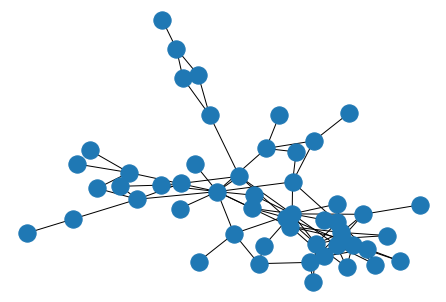

In [ ]:
nx.draw(second_largest)

In [ ]:
color_map = ["green", "blue", "red", "yellow", "black", "purple", "grey"]
f=0
nodes = {n:'' for n in second_largest.nodes}
for nod in second_largest.nodes:
  if nodes[nod]=='':
    nodes[nod] = color_map[f]
    for n, _ in model.most_similar(nod):
      if nodes[n] == '':
        nodes[n] = color_map[f]


In [ ]:
print(nx.info(giant)) 

Name: 
Type: Graph
Number of nodes: 51489
Number of edges: 58375
Average degree:   2.2675
